In [90]:
import os
try:
    print(file_path)
except:
    file_path = os.path.abspath('')
    os.chdir(os.path.dirname(file_path))
    print(file_path)

d:\Project\liveness_vit\notebook


In [91]:
import sys
sys.path.append("")

In [92]:
import torch 
import torch.nn as nn

from skimage import io
import timm
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

In [93]:
im_path = "image_test/faketwo.jpg"
model_path = "vit_base_patch16_224.augreg_in21k_ft_in1k"
image_size = 224

In [94]:
def get_image(im_path,shape=image_size):
    img = io.imread(im_path)[:,:,:3]
    org_img = img.copy()
    img = A.Normalize()(image=img)["image"]
    norm_img = img.copy()
    img = np.transpose(img,(2,0,1))
    img = np.expand_dims(img,0)

    img = torch.tensor(img)
    img = nn.Upsample((shape,shape))(img)
    
    return img,norm_img, org_img

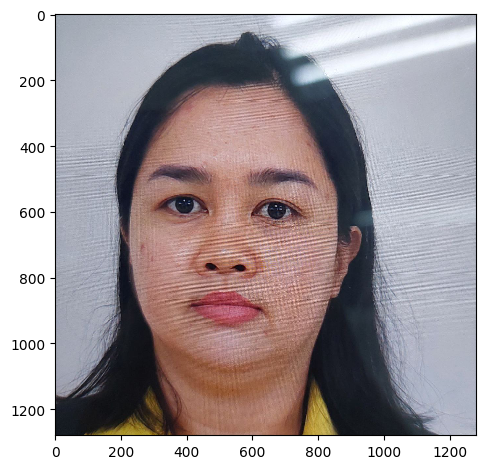

In [95]:
img,norm_img, org_img = get_image(im_path)
io.imshow(org_img)

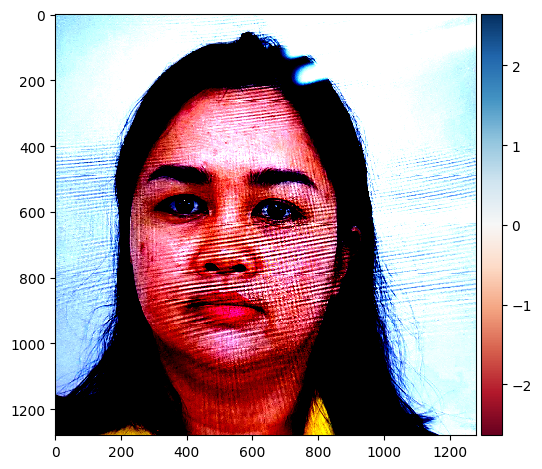

In [96]:
io.imshow(norm_img)

In [97]:
# import timm
# model = timm.create_model(model_path,img_size=image_size, dynamic_img_size=True,pretrained=True).cuda()

In [98]:
device ='cuda'

In [99]:
MODEL_DIR='models/liveness/weights/vit_teacher_new_config_siw.pth'
model = timm.create_model('vit_base_patch16_224.augreg_in21k_ft_in1k', img_size=image_size, dynamic_img_size=True,pretrained=True)
model.head = torch.nn.Linear(model.head.in_features, 2)
model = model.to(device)
model.load_state_dict(
    torch.load(
        MODEL_DIR
    )
)
model.eval()

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg_in21k_ft_in1k)
INFO:timm.models._hub:[timm/vit_base_patch16_224.augreg_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [100]:
outputs = {}
def get_outputs(name):
    def hook(model, input, output):
            outputs[name] = output.detach()
        
    return hook

In [101]:
model.cuda().blocks[-1].attn.q_norm.register_forward_hook(get_outputs('q'))
model.cuda().blocks[-1].attn.k_norm.register_forward_hook(get_outputs('k'))
# model.cuda().blocks[-1].attn.qkv.register_forward_hook(get_outputs('qkv',model.cuda().blocks[-1].attn))

model.cuda().blocks[-1].register_forward_hook(get_outputs('last_layer'))
model.cuda()(img.cuda())

tensor([[ 1.3355, -2.8476]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [102]:
outputs["attentions"] = outputs["q"] @ outputs["k"].transpose(-2, -1)

In [103]:
outputs["attentions"].shape ## B, num_heads, num_patches+1,num_patches+1

torch.Size([1, 12, 197, 197])

In [104]:
print(
"\n last_hidden_state",outputs["last_layer"].shape, 
"\n attentions last layer", outputs["attentions"].shape, 
)


 last_hidden_state torch.Size([1, 197, 768]) 
 attentions last layer torch.Size([1, 12, 197, 197])


In [105]:
if image_size==224:
    map_size = int(np.sqrt(196))
elif image_size==1024:
    map_size = int(np.sqrt(4096))

## Visualizing Feature Vector Outputs patchwise based on mean

In [106]:
feature =  outputs["last_layer"] ## 1xnum_patches+1x768

In [107]:
feature_map = feature.mean(axis=-1) ## taking mean at feature axis ## [num_patches+1x]
feature_map = feature_map[:,1:] ## removing cls token ## [1,num_patches]


feature_map = feature_map.view(1,1,map_size,map_size) ## adding channel axis for upsample

print(feature_map.shape)
feature_map = nn.functional.interpolate(feature_map.view(1, 1, map_size,map_size), (224, 224), mode='bicubic').view(224, 224, 1).squeeze(-1).detach().cpu().numpy()
# feature_map = feature_map.squeeze(-1).detach().cpu().numpy()

# feature_map = nn.Upsample(size=(image_size,image_size))(feature_map)
print(feature_map.shape)

torch.Size([1, 1, 14, 14])
(224, 224)


In [108]:
# feature_map[0,0,:,:].detach().cpu().numpy().shape

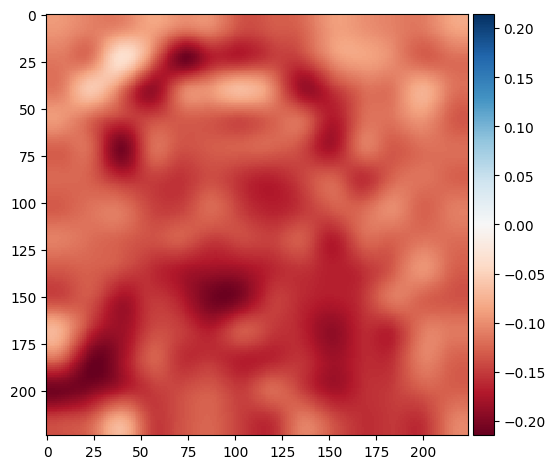

In [109]:
# feature_map = feature_map[0,0,:,:].detach().cpu().numpy()

# feature_map = (feature_map-feature_map.min())/(feature_map.max()-feature_map.min())
io.imshow(feature_map)

## Visualizing Attentions Vector Outputs patchwise based on mean

In [110]:
attentions = outputs["attentions"] ## 1xnum_heads,num_patches+1x768
print(attentions.shape)

torch.Size([1, 12, 197, 197])


(224, 224)


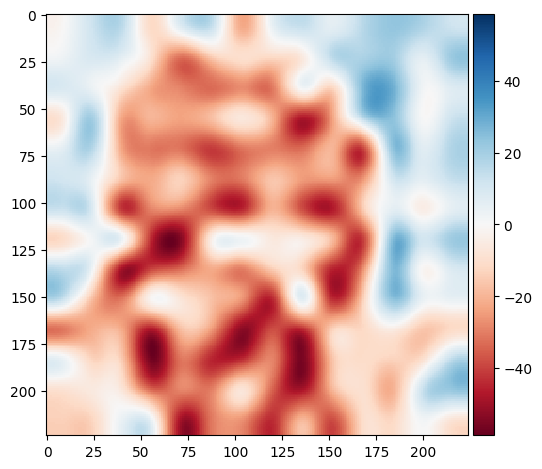

(224, 224)


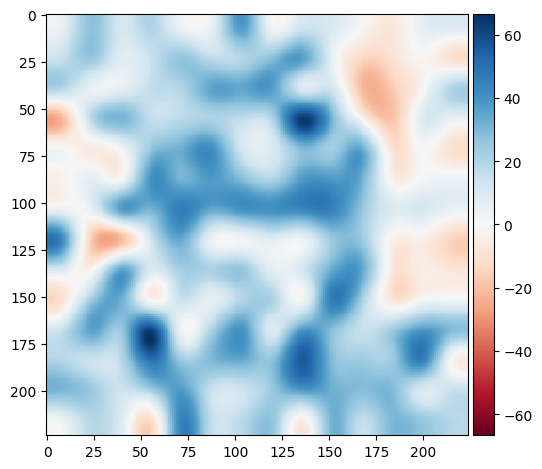

(224, 224)


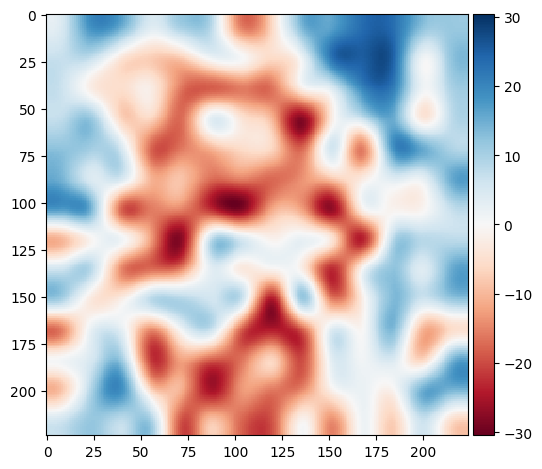

(224, 224)


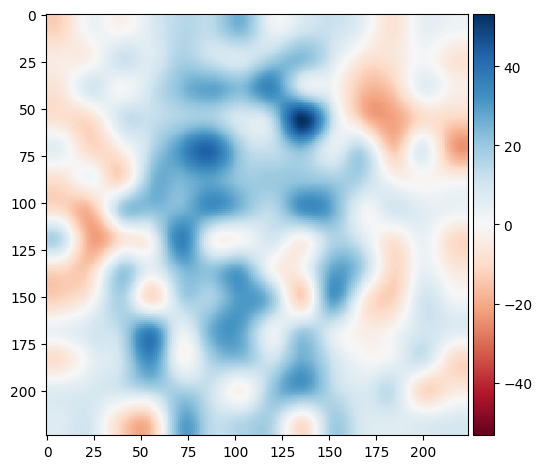

(224, 224)


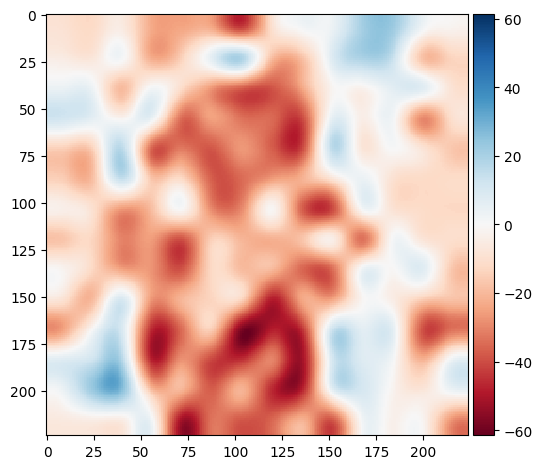

(224, 224)


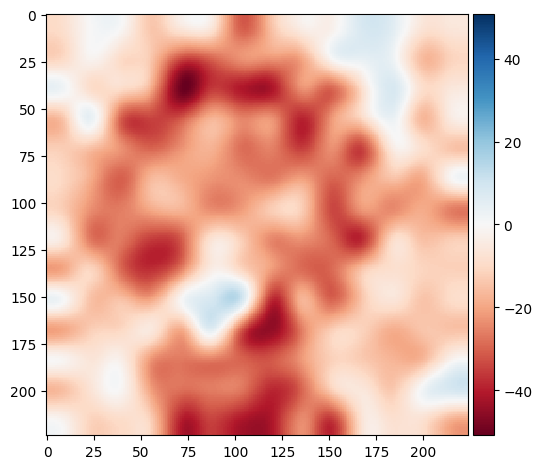

(224, 224)


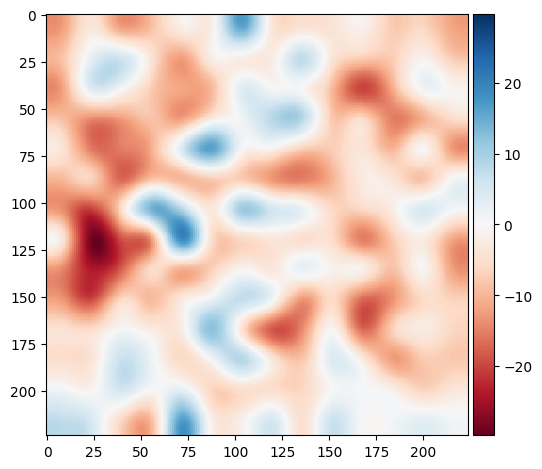

(224, 224)


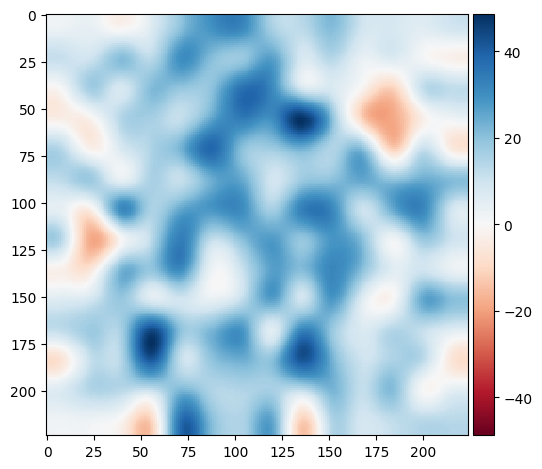

(224, 224)


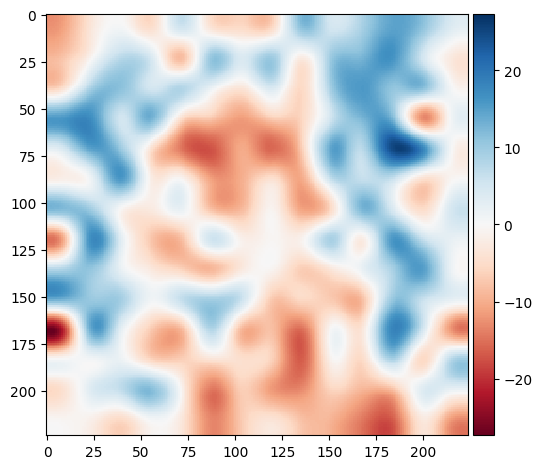

(224, 224)


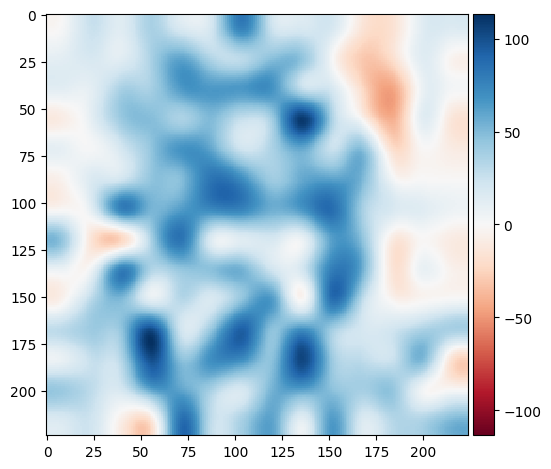

(224, 224)


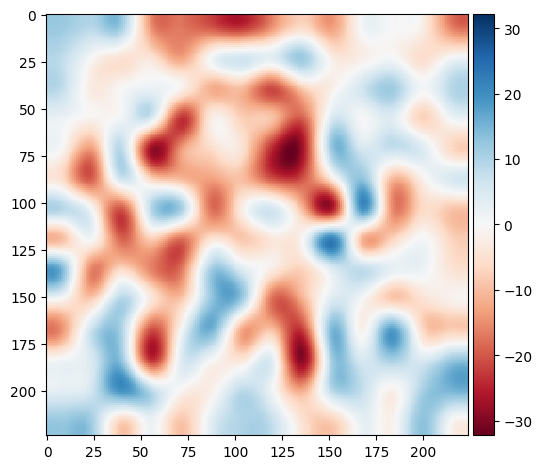

(224, 224)


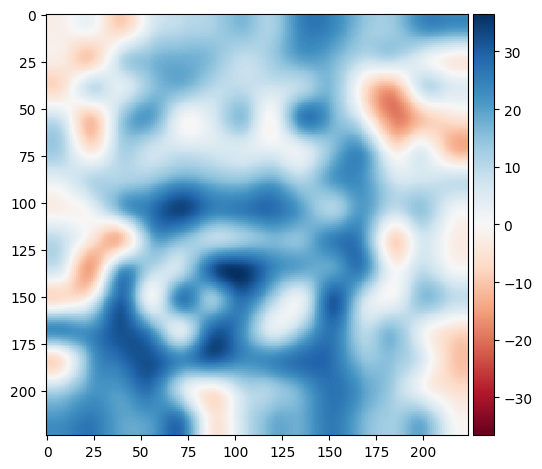

In [111]:
num_heads = attentions.shape[1]

for attention_head in range(num_heads):  
    attentions_map = attentions[:,attention_head,:,0]
    attentions_map = attentions_map[:,1:] ## removing cls token ## [1,num_patches]
#     map_size = int(np.sqrt(4096))

    attentions_map = attentions_map.view(1,1,map_size,map_size) ## adding channel axis for upsample

    attentions_map = nn.functional.interpolate(attentions_map.view(1, 1, map_size,map_size), (224, 224), mode='bicubic').view(224, 224, 1).squeeze(-1).detach().cpu().numpy()
    print(attentions_map.shape)

    # attentions_map = attentions_map[0,0,:,:].detach().cpu().numpy()

#     attentions_map = (attentions_map-attentions_map.min())/(attentions_map.max()-attentions_map.min())
    io.imshow(attentions_map)
    plt.show()
    

## Visualizing Attentions Vector Outputs patchwise based on mean of all heads

In [116]:
attentions = outputs["attentions"] ## 1xnum_patches+1x768
print(attentions.shape)

torch.Size([1, 12, 197, 197])


torch.Size([1, 1, 224, 224])


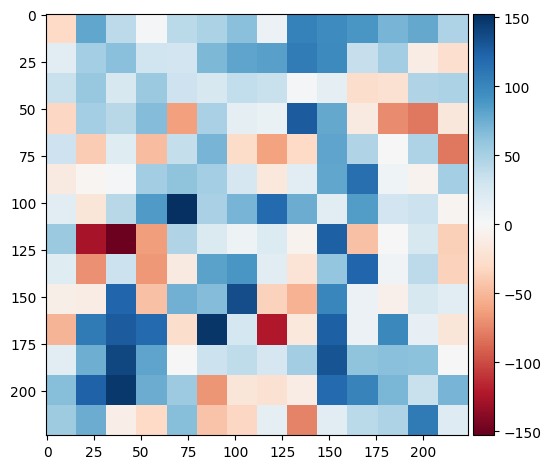

In [118]:
attentions_map = attentions.sum(axis=1)
attentions_map = attentions_map[:,:,0]
attentions_map = attentions_map[:,1:] ## removing cls token ## [1,num_patches]

attentions_map = attentions_map.view(1,1,map_size,map_size) ## adding channel axis for upsample


attentions_map = nn.Upsample(size=(image_size,image_size))(attentions_map)
print(attentions_map.shape)

attentions_map = attentions_map[0,0,:,:].detach().cpu().numpy()

#     attentions_map = (attentions_map-attentions_map.min())/(attentions_map.max()-attentions_map.min())
io.imshow(attentions_map)
plt.show()